# Working with wheel data

This example will give you information about how the rotary encoder records wheel movements, how to find out the units and spatial resolution of the standard wheel data, and how to load the wheel data.  There are also examples of how to load wheel movements and rection times from ALF datasets and DataJoint tables, as well as how to calculate these from scratch.

In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from one.api import ONE

from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times

one = ONE()
sns.set_style('whitegrid')

In [2]:
eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
print(one.eid2ref(eid, as_dict=False))

2020-09-21_1_SWC_043


### Device

The standard resolution of the rotary encoder is 1024 'ticks' per revolulation.  With quadrature (X4) encoding we measure four fronts giving from the device: low -> high and high -> low, from channels A and B.  Therefore the number of measured 'ticks' per revolution becomes 4096.

X4 encoding is used in ephys sessions, while in training sessions the encoding is X1, i.e. four times fewer ticks per revolution.

![Quadrature encoding schematic](http://www.ni.com/cms/images/devzone/tut/ipuuzhqc3503.jpg)

For more information on the rotary encoder see these links:

* [National Instruments guide to rotary encoders](http://www.ni.com/tutorial/7109/en/)
* [Datasheet for the Kuebler](https://www.kuebler.com/pdf?2400-2420_en.pdf)

### Units
The wheel module contains some default values that are useful for determining the units of the raw data, and for interconverting your ALF position units.

In [3]:
device_info = ('The wheel diameter is {} cm and the number of ticks is {} per revolution'
               .format(wh.WHEEL_DIAMETER, wh.ENC_RES))
print(device_info)

The wheel diameter is 6.2 cm and the number of ticks is 4096 per revolution


### Loading the wheel data
The wheel traces can be accessed via ONE.  There are two ALF files: `wheel.position` and `wheel.timestamps`.  The timestamps are, as usual, in seconds (same as the trials object) and the positions are in radians.  The positions are not evenly sampled, meaning that when the wheel doesn't move, no position is registered.  For reference,

More information on the ALF dataset types can be found [here](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.hnjqyfnroyya).

**NB**: There are some old `wheel.velocity` ALF files that contain the volocity measured as the diff between neighbouring samples.  Later on we describe a better way to calculate the velocity.

In [4]:
wheel = one.load_object(eid, 'wheel', collection='alf')

print('wheel.position: \n', wheel.position)
print('wheel.timestamps: \n', wheel.timestamps)

wheel.position: 
 [ 1.53398079e-03 -0.00000000e+00 -1.53398079e-03 ... -4.52088682e+02
 -4.52090216e+02 -4.52091750e+02]
wheel.timestamps: 
 [2.64973500e-02 3.13635300e-02 3.42632400e-02 ... 4.29549951e+03
 4.29570042e+03 4.29584134e+03]


### Loading movement data
There is also an ALF dataset type called 'wheelMoves' with two attributes:
1. `wheelMoves.intervals` - An N-by-2 arrays where N is the number of movements detected.  The first column contains the movement onset time in absolute seconds; the second contains the offset.
2. `wheelMoves.peakAmplitude` - The absolute maximum amplitude of each detected wheel movement, relative to onset position.  This can be used to determine whether the movement was particularly large and therefore whether it was a flinch vs a determined movement.

If the dataset doesn't exist you can also extract the wheel moves with a single function.  Below we attempt to load the wheelMoves ALF and upon failing, extract it ourselves.

In [5]:
try:
    # Warning: Some older sessions may not have a wheelMoves dataset
    wheel_moves = one.load_object(eid, 'wheelMoves', collection='alf')
except AssertionError:
    wheel_moves = extract_wheel_moves(wheel.timestamps, wheel.position)

### The movements algorithm
The wheel movement onsets and offsets are calculated using the `wheel.movements` function.  The output of this function is saved in the 'wheelMoves' ALF.

Refer to the `wheel.movements` function docstring for details of how the movements are detected.  In addition to the data found in the wheelMoves object, the function outputs an array of peak velocity times.  Also the function has a `make_plots` flag which will produce plots of the wheel position and velocity with the movement onsets and offsets highlighted (see below).

The movements algorithm requires the positions and timestamps to be evenly sampled so they should be interpolated first, which can be done with the `wheel.interpolate_position` function.  The default sampling frequency is 1000Hz:

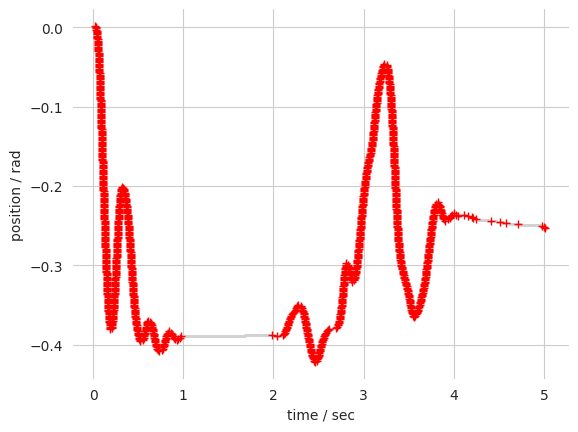

In [6]:
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 5  # Number of seconds to plot
plt.figure()

# Plot the interpolated data points
mask = t < (t[0] + sec)
plt.plot(t[mask], pos[mask], '.', markeredgecolor='lightgrey', markersize=1)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)
plt.show()

Once interpolated, the movements can be extracted from the position trace.  **NB**: The position thresholds are dependant on the wheel position units.  The defaults values are for the raw input of a X4 1024 encoder, so we will convert them to radians:

In [7]:
# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)

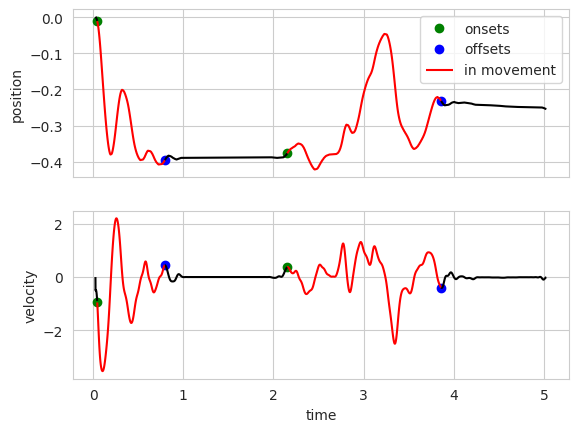

In [8]:
# Detect wheel movements for the first 5 seconds
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)
plt.show()

The `onsets` and `offsets` are stored in the `wheelMoves.intervals` dataset.

For scale, the stimulus must be moved 35 visual degrees to reach threshold.  The wheel gain is 4 degrees/mm (__NB__: the gain is double for the first session or so, see [Appendix 2 of the behavior paper](https://docs.google.com/document/d/1RA6wgbWfxD2kGlpNxt0n3HVcW4TEIx8e-YO7k_W1pHs/edit))

In [9]:
threshold_deg = 35 # visual degrees
gain = 4  # deg / mm
threshold_rad = wh.cm_to_rad(1e-1) * (threshold_deg / gain)  # rad

print('The wheel must be turned ~%.1f rad to move the stimulus to threshold' % threshold_rad)

The wheel must be turned ~0.3 rad to move the stimulus to threshold


### Calculating velocity
Wheel velocity can be calculated using the `velocity_filtered` function, which returns the velocity and acceleration passed through a (non-causal) 20 Hz low-pass Butterworth filter.
As with the `movements` function, the input is expected to be evenly sampled, therefore you should interpolate the wheel data before calling this function.

<div class="alert alert-block alert-info">
<b>Info:</b> Why filter?
From the sampling distribution, there is no antialiasing needed, but the imprecision on the timestamps + positions gives a noisy estimate of the velocity.
</div>

In [10]:
# pos was the output of interpolate_position using the default frequency of 1000Hz
Fs = 1000
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position, freq=Fs)
vel, acc = wh.velocity_filtered(pos, Fs)

### Last move onset
The \_ibl\_trials.firstMovement_times dataset contains the timestamps of the first recorded movement in a trial.
The `get_movement_onset` function will find the times at which movement started, given an event timestamp that occurred during the movement.
In the following example we find the onsets of the movements that led to a feedback response and calculate the movement response time for each trial.

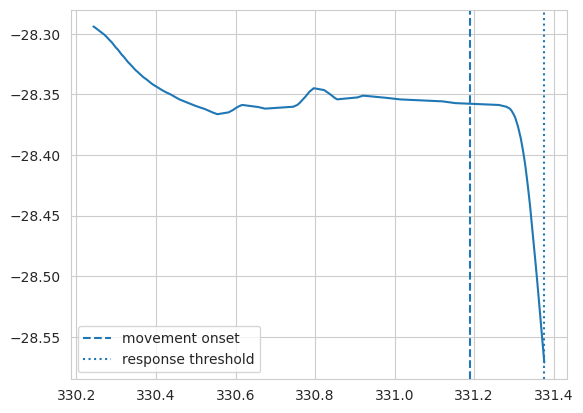

In [11]:
trial_data = one.load_object(eid, 'trials', collection='alf')
ts = wh.get_movement_onset(wheel_moves.intervals, trial_data.response_times)

# The time from final movement onset to response threshold
movement_response_times = trial_data.response_times - ts

idx = 15 # trial index
mask = np.logical_and(trial_data['goCue_times'][idx] < t, t < trial_data['feedback_times'][idx])
plt.figure();
plt.plot(t[mask], pos[mask]);
plt.axvline(x=ts[idx], label='movement onset', linestyle='--');
plt.axvline(x=trial_data.response_times[idx], label='response threshold', linestyle=':');
plt.legend()
plt.show()

### Calculating reaction times
Reaction times based on wheel movements can be calculated with the `load_wheel_reaction_times` function which is located in the behavior module of brainbox.

Reaction times are defined as the time between the go cue (onset tone) and the onset of the first substantial wheel movement.  A movement is considered sufficiently large if its peak amplitude is at least 1/3rd of the distance to threshold (~0.1 radians).

Negative times mean the onset of the movement occurred before the go cue.  Nans may occur if there was no detected movement withing the period, or when the goCue_times or feedback_times are nan.

The function loads the trials object and if `firstMovement_times` is not present it loads the wheel moves and extracts these times.

In [12]:
eid = 'c7bd79c9-c47e-4ea5-aea3-74dda991b48e'
print('Session ' + one.eid2ref(eid, as_dict=False))
wheel = one.load_object(eid, 'wheel', collection='alf')
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
vel, acc = wh.velocity_filtered(pos, 1e3)

# Load the reaction times
# brainbox.io.one.load_wheel_reaction_times
rt = load_wheel_reaction_times(eid)

Session 2020-09-19_1_CSH_ZAD_029


/opt/hostedtoolcache/Python/3.12.9/x64/lib/python3.12/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-02-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


/opt/hostedtoolcache/Python/3.12.9/x64/lib/python3.12/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-02-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


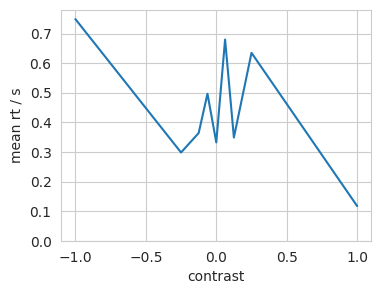

In [13]:
trial_data = one.load_object(eid, 'trials', collection='alf')

# # Replace nans with zeros
trial_data.contrastRight[np.isnan(trial_data.contrastRight)] = 0
trial_data.contrastLeft[np.isnan(trial_data.contrastLeft)] = 0

contrast = trial_data.contrastRight - trial_data.contrastLeft
mean_rt = [np.nanmean(rt[contrast == c]) for c in set(contrast)]

# RT may be nan if there were no detected movements, or if the goCue or stimOn times were nan
xdata = np.unique(contrast)
plt.figure(figsize=(4, 3))  # Some sort of strange behaviour in this cell's output
plt.plot(xdata, mean_rt);

plt.xlabel('contrast')
plt.ylabel('mean rt / s')
plt.ylim(bottom=0);
plt.show()

### Finding reaction time and 'determined' movements
Below is an example of how you might filter trials by those responses that are unambiguous.  The function `extract_first_movement_times` is used for calculating the trial reaction times but also returns whether the first significant movement was 'final', i.e. was the one that reached threshold.  For details of how 'first movement' is defined, see the function docstring.

In [14]:
wheel_moves = one.load_object(eid, 'wheelMoves', collection='alf')
firstMove_times, is_final_movement, ids = extract_first_movement_times(wheel_moves, trial_data)

2025-02-12 15:52:48 INFO     training_wheel.py:358  minimum quiescent period assumed to be 200ms


#### Direction changes
Below is an example of how to plot the times that the wheel changed direction.  Changing the smoothing window when calculating the velocity may improve the detected changes, depending on what your goal is.

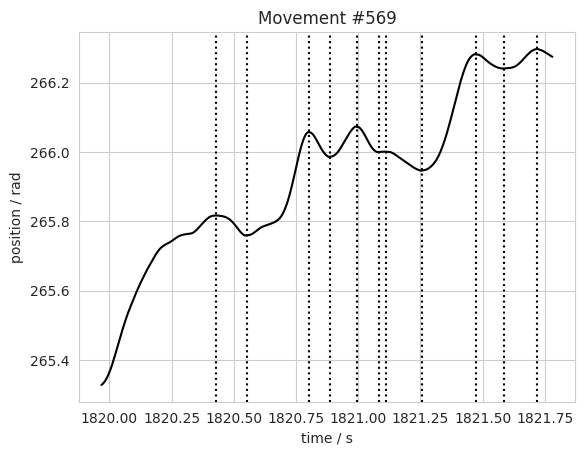

In [15]:
n = 569
on, off = wheel_moves['intervals'][n,]
mask = np.logical_and(t > on, t < off)
sng = np.sign(vel[mask])
idx, = np.where(np.diff(sng) != 0)

plt.figure()
plt.plot(t[mask], pos[mask], 'k')
for i in idx:
    plt.axvline(x=t[mask][i], color='k', linestyle=':')

plt.title('Movement #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');
plt.show()

The function `direction_changes` does the same as above, returning a list of times and indices of each movement's direction changes.

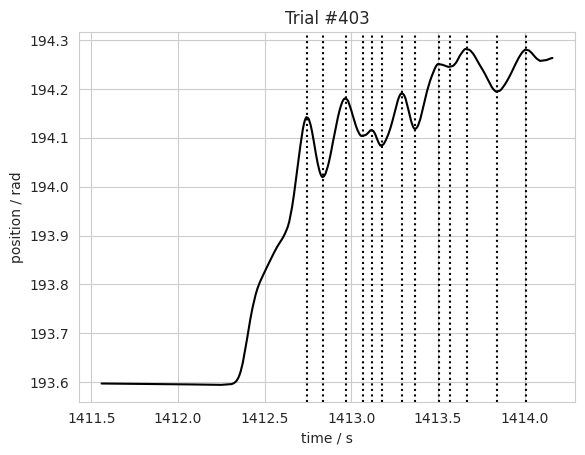

In [16]:
n = 403  # trial number
start, end = trial_data['intervals'][n,]  # trial intervals
intervals = wheel_moves['intervals']  # movement onsets and offsets

# Find direction changes for a given trial
mask = np.logical_and(intervals[:,0] > start, intervals[:,0] < end)
change_times, idx, = wh.direction_changes(t, vel, intervals[mask])

plt.figure()
mask = np.logical_and(t > start, t < end)  # trial intervals mask
plt.plot(t[mask], pos[mask], 'k')  # plot wheel trace for trial
for i in np.concatenate(change_times):
    plt.axvline(x=i, color='k', linestyle=':')

plt.title('Trial #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');
plt.show()

### Splitting wheel trace by trial
To plot a selection of 'determined' movements, we can split the traces using the `traces_by_trial` function.

*NB*: This using the `within_ranges` function which is generic and can be used to detect which points are within a range.  This is useful for returning masks for slicing (must be cast to bool), to label points within ranges or to dectect whether any points belong to more than one range.

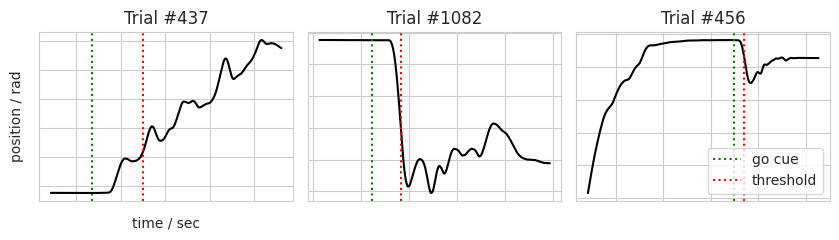

In [17]:
n_trials = 3  # Number of trials to plot
# Randomly select the trials to plot
trial_ids = np.random.randint(trial_data['choice'].size, size=n_trials)
fig, axs = plt.subplots(1, n_trials, figsize=(8.5,2.5))
plt.tight_layout()

# Plot go cue and response times
goCues = trial_data['goCue_times'][trial_ids]
responses = trial_data['response_times'][trial_ids]

# Plot traces between trial intervals
starts = trial_data['intervals'][trial_ids, 0]
ends = trial_data['intervals'][trial_ids, 1]
# Cut up the wheel vectors
traces = wh.traces_by_trial(t, pos, start=starts, end=ends)
zipped = zip(traces, axs, goCues, responses, trial_ids)

for (trace, ax, go, resp, n) in zipped:
    ax.plot(trace[0], trace[1], 'k-')
    ax.axvline(x=go, color='g', label='go cue', linestyle=':')
    ax.axvline(x=resp, color='r', label='threshold', linestyle=':')
    ax.set_title('Trial #%s' % n)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add labels to first
axs[0].set_xlabel('time / sec')
axs[0].set_ylabel('position / rad')
plt.legend();
plt.tight_layout()
plt.show()